我選擇的是最小的資料規模，因為換到大一點的資料，我的記憶體就沒辦法load了。
選擇這麼小的data，結果movie和user的個數是差不多的。

# 程式碼

只import方便做資料處理的lib，演算法是自幹的陽春版本。

In [46]:
%pylab inline
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [47]:
# Load data
train = pd.read_table('ml-100k/u2.base', header=None, names=['uid', 'mid', 'rating', 'timestamp'])
test  = pd.read_table('ml-100k/u2.test', header=None, names=['uid', 'mid', 'rating', 'timestamp'])

n_users  = int(train.describe().loc['max', 'uid'])
n_movies = int(train.describe().loc['max', 'mid'])

 - $Y_{i, j}$放第$j$個使用者對第$i$部電影所做的評分
 - $R_{i, j}=1$代表第$j$個使用者對第$i$部電影有評分，$R_{i, j}=0$則無

In [48]:
# Transform
Y = np.zeros( (n_movies, n_users) )
R = Y.copy()
for i in range(train.shape[0]):
    Y[train.mid[i]-1][train.uid[i]-1] = train.rating[i]
    R[train.mid[i]-1][train.uid[i]-1] = 1

# Item-based Collaborative Filtering

In [50]:
# Allocate
weights    = np.empty((n_movies,n_movies))
diff       = np.empty((n_movies, n_users))
std_rating = np.empty(n_movies)

Y_mu = Y.sum(axis=1)/R.sum(axis=1)
item_has_rated = (R.sum(axis=1)!=0)
user_has_rated = (R.sum(axis=0)!=0)
R_movie = np.array([1 if i in item_has_rated else 0 for i in range(n_movies)])
for i in range(n_movies):
    diff[i,:] = Y[i,:]-Y_mu[i]
    std_rating[i] = np.power(diff[i,:],2).sum()/(R[i,:].sum())

In [51]:
# Weighting (Pearson correlation)
R_weights = np.zeros((n_movies, n_movies))
rate_avg = Y.sum()/float(R.sum())
for i in range(n_movies):
    for j in range(n_movies):
        stdmstd = std_rating[i]*std_rating[j]
        weights[i,j] = np.dot(R[i,:]*diff[i,:], R[j,:]*diff[j,:])/(stdmstd)
        #weights[i,j] = np.dot(R[i,:]*(Y[i,:]-rate_avg), R[j,:]*(Y[j,:]-rate_avg))/(stdmstd) # (constrainted Pearson)
        if stdmstd!=0:
            R_weights[i,j] = 1

試著調整neighborhood subset的大小來看結果的變化，觀察$K=\{1,\cdots,200\}$

In [52]:
rec_item_based = np.empty((2,200))
pred_correlation = np.empty(test.shape[0])
pred_flag        = pred_correlation.copy()
for iter in range(200):
    K   = iter+1
    tolerence = .5
    count_not_available = 0
    for test_id in range(test.shape[0]):
        a = test.uid[test_id]
        i = test.mid[test_id]

        if not user_has_rated[a] or not item_has_rated[i]:
            count_not_available = count_not_available + 1
            pred_flag[test_id] = 0
        else:
            weights_i = weights[i,:]*R_weights[i,:]
            sort_index = np.argsort(-weights_i)
            idx_positive_weights    = np.array(sort_index[:K])
            val_positive_weights    = weights_i[idx_positive_weights]
            val_positive_difference = (diff[idx_positive_weights,a]) * (R[idx_positive_weights,a])
            pred_correlation[test_id] = Y_mu[i] + np.dot(val_positive_difference,val_positive_weights)/(val_positive_weights.sum())

            pred_flag[test_id] = 1
    pred_has_pred = [i for i in range(test.shape[0]) if pred_flag[i]]
    # Validation
    error_item_based   = test.rating.iloc[pred_has_pred] - pred_correlation[np.ix_(pred_has_pred)]
    correct = np.array(error_item_based.loc[abs(error_item_based)<tolerence])
    rec_item_based[0, iter] = correct.shape[0]/float(test.shape[0])
    correct = np.array(error_item_based.loc[abs(error_item_based)<1])
    rec_item_based[1, iter] = correct.shape[0]/float(test.shape[0])

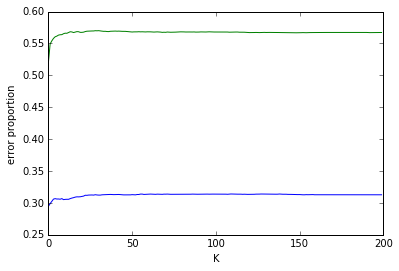

In [53]:
plot(rec_item_based[0,:])
plot(rec_item_based[1,:])
xlabel("K")
ylabel("error proportion")


上圖的紅線代表誤差在(-1,1)佔所有testing的比值, 藍線代表誤差在(-0.5,0.5)的比值, K在20,30之後幾乎沒有變化

In [54]:
# Predict
pred_correlation = np.empty(test.shape[0])
pred_flag        = pred_correlation.copy()
K         = 50
tolerence = .5
count_not_available = 0
for test_id in range(test.shape[0]):
    a = test.uid[test_id]
    i = test.mid[test_id]

    if not user_has_rated[a] or not item_has_rated[i]:
        count_not_available = count_not_available + 1
        pred_flag[test_id] = 0
    else:
        weights_i = weights[i,:]*R_weights[i,:]
        sort_index = np.argsort(-weights_i)
        idx_positive_weights    = np.array(sort_index[:K])
        val_positive_weights    = weights_i[idx_positive_weights]
        val_positive_difference = (diff[idx_positive_weights,a]) * (R[idx_positive_weights,a])
        pred_correlation[test_id] = Y_mu[i] + np.dot(val_positive_difference,val_positive_weights)/(val_positive_weights.sum())

        pred_flag[test_id] = 1
pred_has_pred = [i for i in range(test.shape[0]) if pred_flag[i]]

In [55]:
# Validation
tolerence = .5
error_item_based   = test.rating.iloc[pred_has_pred] - pred_correlation[np.ix_(pred_has_pred)]
correct = np.array(error_item_based.loc[abs(error_item_based)<tolerence])
correct_proportion = correct.shape[0]/float(test.shape[0])

('Correct proportion:', 0.31265)
('Converge:', 0.9981)
('MAE:', 0.13755823704890777)


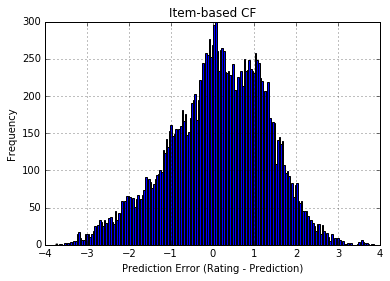

In [56]:
# Visualization
error_item_based.hist(bins=200)
plt.xlabel("Prediction Error (Rating - Prediction)")
plt.ylabel("Frequency")
plt.title("Item-based CF")
print ('Correct proportion:', correct_proportion)
print ('Converge:',  1 - (count_not_available/float(test.shape[0])))
print ('MAE:', error_item_based.mean())

# User-based Collaborative Filtering

In [57]:
# Load data
train = pd.read_table('ml-100k/u2.base', header=None, names=['uid', 'mid', 'rating', 'timestamp'])
test  = pd.read_table('ml-100k/u2.test', header=None, names=['uid', 'mid', 'rating', 'timestamp'])

n_users  = int(train.describe().loc['max', 'uid'])
n_movies = int(train.describe().loc['max', 'mid'])

In [58]:
# Transform
Y = np.zeros( (n_movies, n_users) )
R = Y.copy()
for i in range(train.shape[0]):
    Y[train.mid[i]-1][train.uid[i]-1] = train.rating[i]
    R[train.mid[i]-1][train.uid[i]-1] = 1

In [59]:
# Allocate
weights    = np.empty((n_users,n_users))
diff       = np.empty((n_movies, n_users))
std_rating = np.empty(n_users)

Y_mu = Y.sum(axis=0)/R.sum(axis=0)
item_has_rated = (R.sum(axis=1)!=0)
user_has_rated = (R.sum(axis=0)!=0)
R_users = np.array([1 if i in user_has_rated else 0 for i in range(n_users)])
for i in range(n_users):
    diff[:,i] = Y[:,i]-Y_mu[i]
    std_rating[i] = np.power(diff[:,i],2).sum()/(R[:,i].sum())

In [60]:
# Weighting (Pearson correlation)
R_weights = np.zeros((n_users, n_users))
rate_avg = Y.sum()/float(R.sum())
for i in range(n_users):
    for j in range(n_users):
        stdmstd = std_rating[i]*std_rating[j]
        weights[i,j] = np.dot(R[:,i]*diff[:,i], R[:,j]*diff[:,j])/(stdmstd)
        #weights[i,j] = np.dot(R[:,i]*(Y[:,i]-rate_avg), R[:,j]*(Y[:,j]-rate_avg))/(stdmstd) # (constrainted Pearson)
        if stdmstd!=0:
            R_weights[i,j] = 1

In [65]:
rec_user_based = np.empty((2,200))
pred_correlation = np.empty(test.shape[0])
pred_flag        = pred_correlation.copy()
for iter in range(200):
    K   = iter+1
    tolerence = .5
    count_not_available = 0
    for test_id in range(test.shape[0]):
        a = test.uid[test_id]
        i = test.mid[test_id]
        if not user_has_rated[a] or not item_has_rated[i]:
            count_not_available = count_not_available + 1
            pred_flag[test_id] = 0
        else:
            weights_i = weights[a,:]*R_weights[a,:]
            sort_index = np.argsort(-weights_i)
            idx_positive_weights    = np.array(sort_index[:K])
            val_positive_weights    = weights_i[idx_positive_weights]
            val_positive_difference = (diff[i,idx_positive_weights] * R[i,idx_positive_weights])
            pred_correlation[test_id] = Y_mu[a] + np.dot(val_positive_difference,val_positive_weights)/(val_positive_weights.sum())
            pred_flag[test_id] = 1
    pred_has_pred = [i for i in range(test.shape[0]) if pred_flag[i]]   
    # Validation
    error_user_based   = test.rating.iloc[pred_has_pred] - pred_correlation[np.ix_(pred_has_pred)]
    correct = np.array(error_user_based.loc[abs(error_user_based)<tolerence])
    rec_user_based[0, iter] = correct.shape[0]/float(test.shape[0])
    correct = np.array(error_user_based.loc[abs(error_user_based)<1])
    rec_user_based[1, iter] = correct.shape[0]/float(test.shape[0])


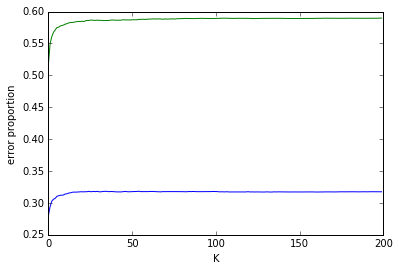

In [66]:
plot(rec_user_based[0,:])
plot(rec_user_based[1,:])
xlabel("K")
ylabel("error proportion")

0.31755


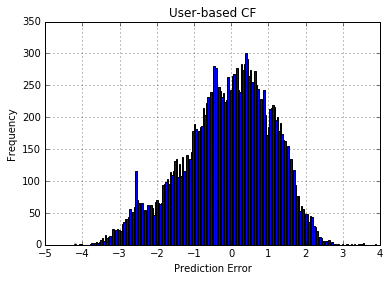

In [67]:
# Predict
pred_correlation = np.zeros(test.shape[0])
pred_flag        = pred_correlation.copy()
pred_cosine      = pred_correlation.copy()
K         = 50
tolerence = .5
count_not_available = 0
for test_id in range(test.shape[0]):
    a = test.uid[test_id]
    i = test.mid[test_id]
    if not user_has_rated[a] or not item_has_rated[i]:
        count_not_available = count_not_available + 1
        pred_flag[test_id] = 0
    else:
        weights_i = weights[a,:]*R_weights[a,:]
        sort_index = np.argsort(-weights_i)
        idx_positive_weights    = np.array(sort_index[:K])
        val_positive_weights    = weights_i[idx_positive_weights]
        val_positive_difference = (diff[i,idx_positive_weights] * R[i,idx_positive_weights])
        pred_correlation[test_id] = Y_mu[a] + np.dot(val_positive_difference,val_positive_weights)/(val_positive_weights.sum())
        pred_flag[test_id] = 1
pred_has_pred = [i for i in range(test.shape[0]) if pred_flag[i]] 
# Validation
error_user_based   = test.rating.iloc[pred_has_pred] - pred_correlation[np.ix_(pred_has_pred)]
correct = np.array(error_user_based.loc[abs(error_user_based)<tolerence])
correct_proportion = correct.shape[0]/float(test.shape[0])

0.31755
('Converge:', 0.9981)
('MAE:', 0.13755823704890777)


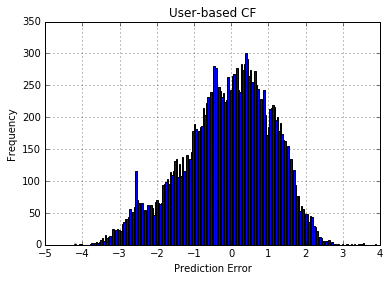

In [68]:
error_user_based.hist(bins=200)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("User-based CF")
print correct_proportion
print ('Converge:',  1 - (count_not_available/float(test.shape[0])))
print ('MAE:', error_item_based.mean())